# posterior analysis

In [3]:
import numpy as np
import pickle
from pathlib import Path
from sbi import analysis
from sbi import utils as utils
from typing import Any, Callable
import sbi.inference
import torch

In [1]:
import os
os.chdir('..')
!pwd

/Volumes/GoogleDrive/My Drive/02. Master_NSC/02. 2023FS/NSC_Thesis/codes


In [91]:
train_id = 5
log_dir = Path(f'./src/train/logs/log_sample_Rchoices{train_id}')
x_dir = Path(f'../data/training_datasets/x_15_{train_id}.pt')
theta_dir = Path(f'../data/training_datasets/theta_15_{train_id}.pt')

In [96]:
def check_method(method):
    try:
        method_fun: Callable = getattr(sbi.inference, method.upper())
    except AttributeError:
        raise NameError("Method not available. `method` must be one of 'SNPE', 'SNLE', 'SNRE'.")
    return method_fun

# load posterior.pkl
density_estimator_dir = log_dir / 'density_estimator.pkl'
with open(density_estimator_dir, 'rb') as f:
    density_estimator = pickle.load(f)

method = 'snpe'
method_fun = check_method(method)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
prior_min_train = [-3.7, 0, 0, -5]
prior_max_train = [2.5, 71, 18, 7]
prior_train = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min_train), high=torch.as_tensor(prior_max_train), device=device
)

inference = method_fun(prior=prior_train,
                       density_estimator='maf',
                       device=device,
                       logging_level='WARNING',
                       # summary_writer=writer,
                       show_progress_bars=True,
                       )
posterior = inference.build_posterior(density_estimator)

## test with **trained** x, theta pair

In [97]:
x = torch.load(x_dir).numpy()
theta = torch.load(theta_dir).numpy()

input x: [0.5 0.6 0.4 0.4 0.6 0.5 0.4 0.4 0.6 0.5 0.6 0.4 0.4 0.4 0.5 1. ]
true params: [ -0.11907339  -8.502241   -17.213118     6.423678  ]


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

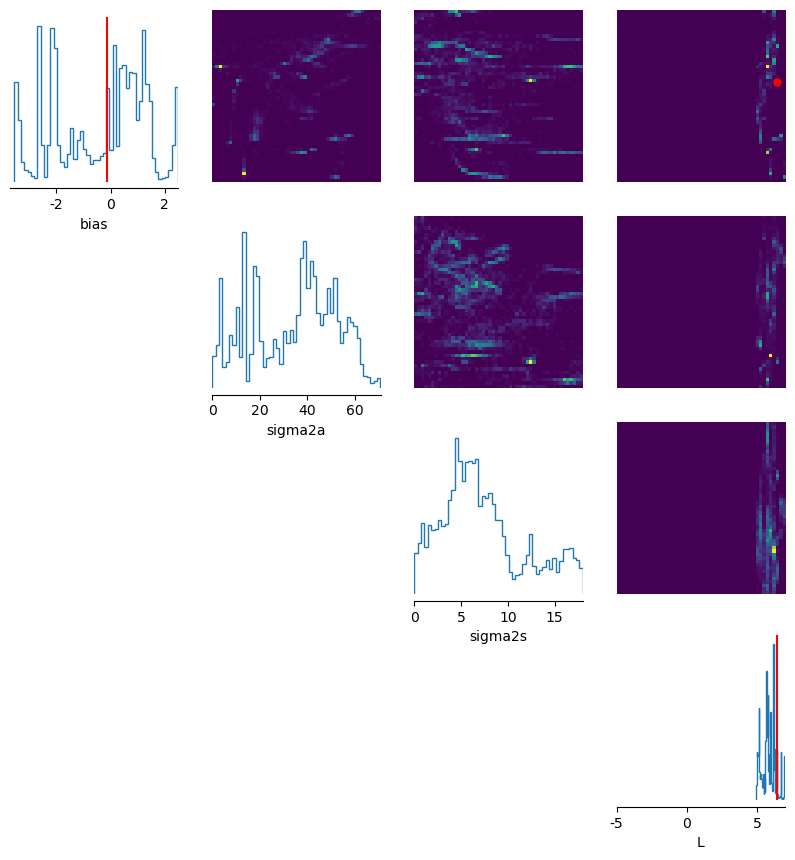

In [98]:
idx = 300
true_params = theta[idx, :]
print(f'input x: {x[idx, :]}')
print(f'true params: {true_params}')
samples = posterior.sample((5000,), x=x[idx, :])
fig, axes = analysis.pairplot(
    samples,
    limits=[[-3.7, 2.5], [0, 71], [0, 18], [-5, 7]],
    # ticks=[[], []],
    figsize=(10, 10),
    points=true_params,
    points_offdiag={'markersize': 10, 'markeredgewidth': 1},
    points_colors='r',
    labels = ['bias', 'sigma2a', 'sigma2s', 'L']
    )

## test with unseen x, theta pair

input_x: [0.5 0.6 0.4 0.4 0.5 0.6 0.5 0.5 0.6 0.4 0.4 0.5 0.6 0.5 0.6 1. ]


/Users/admin/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

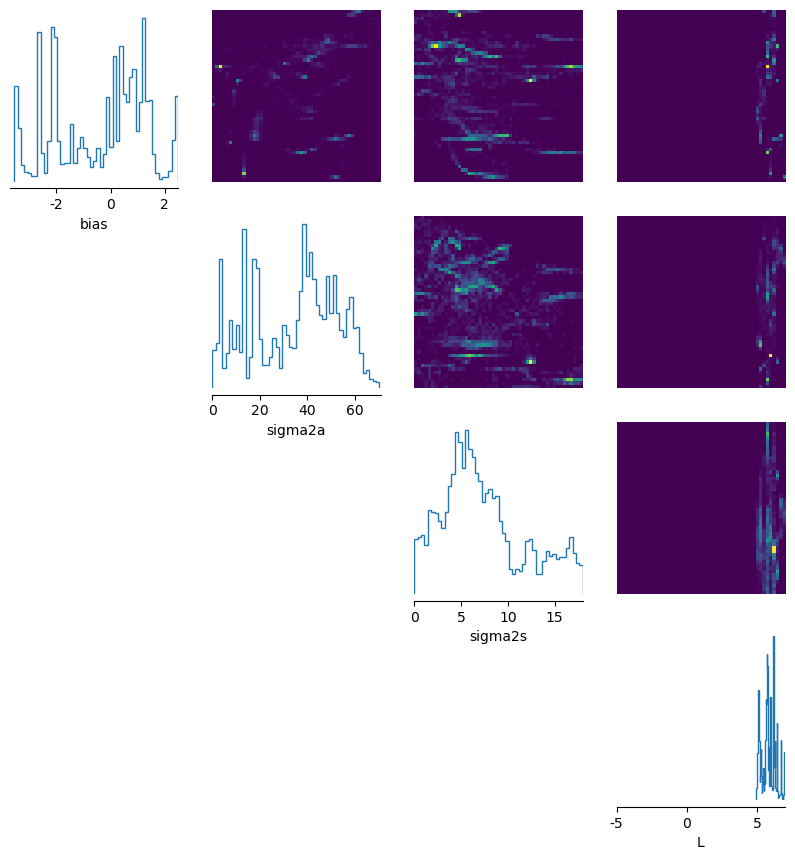

In [99]:
MS = 0.2
x_sample = np.random.choice([-1, 0, 1], size=(1, 14), p=[0.35, 0.3, 0.35])
x_sample = MS*np.insert(x_sample, 0, 0).reshape(1, -1)
# x_sample = x[10, :]
while x_sample in x:
    x_sample = np.random.choice([-1, 0, 1], size=(1, 14), p=[0.35, 0.3, 0.35])
    x_sample = MS*np.insert(x_sample, 0, 0).reshape(1, -1)

# normalize to [-1, 1]
x_sample = (x_sample + 1) / 2
x_sample = np.append(x_sample, 1).reshape(-1)
print(f'input_x: {x_sample}')

samples = posterior.sample((5000,), x=x_sample)
fig, axes = analysis.pairplot(
    samples,
    limits=[[-3.7, 2.5], [0, 71], [0, 18], [-5, 7]],
    # ticks=[[], []],
    figsize=(10, 10),
    # points=true_params,
    points_offdiag={'markersize': 10, 'markeredgewidth': 1},
    points_colors='r',
    labels = ['bias', 'sigma2a', 'sigma2s', 'L']
    )